<a href="https://colab.research.google.com/github/gift-framework/GIFT/blob/main/G2_ML/1.0f/K7_G2_TCS_ExplicitMetric_v1_0f.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# K₇ G₂ TCS Explicit Metric v1.0f

Complete TCS construction pipeline with:
- Full TCS geometry (M₁, Neck, M₂) with ACyl matching
- Neural φ-network with torsion-free training
- Live Laplacian computation and harmonic extraction
- Multi-phase curriculum learning
- Full Yukawa tensor (21×21×77)
- Checkpoint system with automatic resumption

**v1.0f**: Extended training (1500 epochs/phase) + multi-resolution harmonics (8^7 grid)

## 1. Configuration and Imports

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from scipy.sparse import csr_matrix, lil_matrix, diags
from scipy.sparse.linalg import eigsh, spsolve
from scipy.spatial.transform import Rotation
import os
import json
from pathlib import Path
from typing import Dict, Tuple, Optional, List

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

CONFIG = {
    'n_grid': 16,
    'n_grid_harmonics': 8,  # NOUVEAU: grille réduite pour extraction harmonique
    'n_fourier': 10,
    'hidden_dim': 256,
    'n_layers': 6,
    'batch_size': 1024,
    'learning_rate': 5e-4,
    'n_epochs_per_phase': 1500,  # Augmenté de 1000
    'checkpoint_freq': 500,
    'checkpoint_dir': 'checkpoints_v1_0f',

    'tcs': {
        'r_neck_start': 0.35,
        'r_neck_end': 0.65,
        'r_acyl_cutoff': 10.0,
        'twist_angle': np.pi / 3,
    },

    'target': {
        'det_g': 2.0,
        'torsion_norm': 0.0164,
        'b2': 21,
        'b3': 77,
    },

    'yukawa_samples': 200000,
    'torsion_threshold': 1e-6,
    'torsion_floor': 1e-9,  # NOUVEAU: empêche sur-convergence

    'phases': {
        1: {'name': 'TCS_Neck', 'weights': {'dphi': 0.5, 'dpsi': 0.5, 'det': 0.5, 'positivity': 1.0, 'neck_match': 2.0, 'acyl': 0.0, 'harmonicity': 0.0}},
        2: {'name': 'ACyl_Matching', 'weights': {'dphi': 0.3, 'dpsi': 0.3, 'det': 0.8, 'positivity': 1.5, 'neck_match': 0.5, 'acyl': 0.5, 'harmonicity': 0.0}},
        3: {'name': 'Cohomology_Refinement', 'weights': {'dphi': 1.0, 'dpsi': 1.0, 'det': 0.5, 'positivity': 1.0, 'neck_match': 0.5, 'acyl': 1.0, 'harmonicity': 1.0}},
        4: {'name': 'Harmonic_Extraction', 'weights': {'dphi': 2.0, 'dpsi': 2.0, 'det': 1.0, 'positivity': 1.0, 'neck_match': 0.2, 'acyl': 0.5, 'harmonicity': 3.0}},
        5: {'name': 'Final_Calibration', 'weights': {'dphi': 3.0, 'dpsi': 3.0, 'det': 2.0, 'positivity': 2.0, 'neck_match': 0.1, 'acyl': 0.2, 'harmonicity': 2.0}},
    }
}

Path(CONFIG['checkpoint_dir']).mkdir(exist_ok=True)

print(f"Device: {device}")
print(f"Training grid: {CONFIG['n_grid']}^7")
print(f"Harmonics grid: {CONFIG['n_grid_harmonics']}^7")
print(f"Target: b₂={CONFIG['target']['b2']}, b₃={CONFIG['target']['b3']}")
print(f"Epochs per phase: {CONFIG['n_epochs_per_phase']}")
print(f"Phases: {len(CONFIG['phases'])}")

Device: cuda
Training grid: 16^7
Harmonics grid: 8^7
Target: b₂=21, b₃=77
Epochs per phase: 1500
Phases: 5


## 2. Complete TCS Geometry

In [ ]:
class ACylPotentials:
    def __init__(self, r_cutoff: float = 10.0):
        self.r_cutoff = r_cutoff

    def F(self, r: torch.Tensor) -> torch.Tensor:
        """ACyl potential F(r) → 1 as r → ∞."""
        return 1.0 - torch.exp(-r / self.r_cutoff)

    def H(self, r: torch.Tensor) -> torch.Tensor:
        """ACyl potential H(r) → 0 as r → ∞."""
        return torch.exp(-r / self.r_cutoff)

    def dF_dr(self, r: torch.Tensor) -> torch.Tensor:
        return torch.exp(-r / self.r_cutoff) / self.r_cutoff

    def dH_dr(self, r: torch.Tensor) -> torch.Tensor:
        return -torch.exp(-r / self.r_cutoff) / self.r_cutoff


class TCSGeometry:
    def __init__(self, config: Dict):
        self.n = config['n_grid']
        tcs_cfg = config['tcs']

        self.r_neck_start = tcs_cfg['r_neck_start']
        self.r_neck_end = tcs_cfg['r_neck_end']
        self.twist_angle = tcs_cfg['twist_angle']

        self.acyl = ACylPotentials(tcs_cfg['r_acyl_cutoff'])

        self.coords = np.linspace(0, 1, self.n, endpoint=False)

    def radial_coordinate(self, x: torch.Tensor) -> torch.Tensor:
        """Map T⁷ coordinate to radial parameter r ∈ [0,1]."""
        return x[:, 0]

    def region_classification(self, r: torch.Tensor) -> Dict[str, torch.Tensor]:
        """Classify points into M₁, Neck, M₂."""
        m1_mask = r < self.r_neck_start
        neck_mask = (r >= self.r_neck_start) & (r <= self.r_neck_end)
        m2_mask = r > self.r_neck_end

        return {'M1': m1_mask, 'Neck': neck_mask, 'M2': m2_mask}

    def neck_interpolation(self, r: torch.Tensor) -> torch.Tensor:
        """Smooth interpolation χ: 0 in M₁, 1 in M₂."""
        r_norm = (r - self.r_neck_start) / (self.r_neck_end - self.r_neck_start)
        r_norm = torch.clamp(r_norm, 0.0, 1.0)

        chi = 3 * r_norm**2 - 2 * r_norm**3
        return chi

    def twist_map(self, x: torch.Tensor) -> torch.Tensor:
        """Apply twist ψ on neck cross-section S¹×S¹."""
        r = self.radial_coordinate(x)
        chi = self.neck_interpolation(r)

        x_twisted = x.clone()

        theta1 = 2 * np.pi * x[:, 1]
        theta2 = 2 * np.pi * x[:, 2]

        theta1_new = theta1 + chi * self.twist_angle
        theta2_new = theta2 - chi * self.twist_angle

        x_twisted[:, 1] = (theta1_new / (2 * np.pi)) % 1.0
        x_twisted[:, 2] = (theta2_new / (2 * np.pi)) % 1.0

        return x_twisted

    def acyl_metric_correction(self, x: torch.Tensor, g_base: torch.Tensor) -> torch.Tensor:
        """Apply ACyl corrections to metric."""
        r = self.radial_coordinate(x)
        regions = self.region_classification(r)

        F = self.acyl.F(r).unsqueeze(-1).unsqueeze(-1)
        H = self.acyl.H(r).unsqueeze(-1).unsqueeze(-1)

        g_corrected = g_base.clone()

        g_corrected[regions['M1']] = g_base[regions['M1']] * (1.0 + 0.1 * H[regions['M1']])
        g_corrected[regions['M2']] = g_base[regions['M2']] * (1.0 + 0.1 * H[regions['M2']])

        return g_corrected

    def compute_normal_derivative_mismatch(self, phi_net: nn.Module, coords: torch.Tensor, extd) -> torch.Tensor:
        """Compute ACyl normal derivative matching condition."""
        r = self.radial_coordinate(coords)
        regions = self.region_classification(r)

        if not (regions['M1'].any() or regions['M2'].any()):
            return torch.tensor(0.0, device=coords.device)

        epsilon = 1e-4
        coords_plus = coords.clone()
        coords_plus[:, 0] += epsilon
        coords_plus[:, 0] = coords_plus[:, 0] % 1.0

        coords_minus = coords.clone()
        coords_minus[:, 0] -= epsilon
        coords_minus[:, 0] = coords_minus[:, 0] % 1.0

        phi = phi_net(coords)
        phi_plus = phi_net(coords_plus)
        phi_minus = phi_net(coords_minus)

        dphi_dr = (phi_plus - phi_minus) / (2 * epsilon)

        dF_dr = self.acyl.dF_dr(r).unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)
        dH_dr = self.acyl.dH_dr(r).unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)

        expected_derivative = phi * (0.1 * dH_dr)

        mismatch = torch.tensor(0.0, device=coords.device)
        if regions['M1'].any():
            mismatch += ((dphi_dr[regions['M1']] - expected_derivative[regions['M1']]) ** 2).mean()
        if regions['M2'].any():
            mismatch += ((dphi_dr[regions['M2']] - expected_derivative[regions['M2']]) ** 2).mean()

        return mismatch

geometry = TCSGeometry(CONFIG)
print(f"TCS regions: M₁ [0, {geometry.r_neck_start}], Neck [{geometry.r_neck_start}, {geometry.r_neck_end}], M₂ [{geometry.r_neck_end}, 1]")
print(f"Twist angle: {geometry.twist_angle:.4f} rad")

TCS regions: M₁ [0, 0.35], Neck [0.35, 0.65], M₂ [0.65, 1]
Twist angle: 1.0472 rad


## 3. Enhanced φ-Network

In [ ]:
class FourierEncoding(nn.Module):
    def __init__(self, n_freqs: int):
        super().__init__()
        self.n_freqs = n_freqs
        self.register_buffer('freqs', 2 ** torch.arange(n_freqs, dtype=torch.float32))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x_proj = 2 * np.pi * x.unsqueeze(-1) * self.freqs
        return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1).flatten(-2)


class ResidualBlock(nn.Module):
    def __init__(self, dim: int):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, dim),
            nn.LayerNorm(dim),
            nn.GELU(),
            nn.Linear(dim, dim),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return x + self.net(x)


class PhiNetwork(nn.Module):
    def __init__(self, config: Dict):
        super().__init__()
        self.n_freqs = config['n_fourier']
        self.hidden = config['hidden_dim']
        self.n_layers = config['n_layers']

        self.encoding = FourierEncoding(self.n_freqs)
        input_dim = 7 * 2 * self.n_freqs

        self.input_proj = nn.Linear(input_dim, self.hidden)

        self.blocks = nn.ModuleList([
            ResidualBlock(self.hidden) for _ in range(self.n_layers)
        ])

        self.phi_head = nn.Sequential(
            nn.Linear(self.hidden, self.hidden // 2),
            nn.GELU(),
            nn.Linear(self.hidden // 2, 35)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        batch_size = x.shape[0]

        x_enc = self.encoding(x)
        h = self.input_proj(x_enc)

        for block in self.blocks:
            h = block(h)

        phi_flat = self.phi_head(h)

        phi = torch.zeros(batch_size, 7, 7, 7, device=x.device, dtype=x.dtype)

        idx = 0
        for i in range(7):
            for j in range(i+1, 7):
                for k in range(j+1, 7):
                    val = phi_flat[:, idx]

                    phi[:, i, j, k] = val
                    phi[:, i, k, j] = -val
                    phi[:, j, i, k] = -val
                    phi[:, j, k, i] = val
                    phi[:, k, i, j] = val
                    phi[:, k, j, i] = -val

                    idx += 1

        return phi

phi_net = PhiNetwork(CONFIG).to(device)
print(f"φ-network parameters: {sum(p.numel() for p in phi_net.parameters()):,}")

φ-network parameters: 866,083


## 4. G₂ Metric and Hodge Dual

In [ ]:
def compute_g2_metric(phi: torch.Tensor, epsilon: float = 1e-4, phase: int = 1) -> Tuple[torch.Tensor, torch.Tensor]:
    """Compute G₂ metric g_{ij} = (1/6) φ_{ipq} φ_j^{pq}."""
    batch_size = phi.shape[0]
    g = torch.zeros(batch_size, 7, 7, device=phi.device, dtype=phi.dtype)

    for i in range(7):
        for j in range(7):
            g[:, i, j] = (phi[:, i, :, :] * phi[:, j, :, :]).sum(dim=(-2, -1)) / 6.0

    # Force exact symmetrization
    g = (g + g.transpose(-2, -1)) / 2.0

    # Phase-adaptive regularization: stronger throughout
    eps_adaptive = {1: 2e-3, 2: 1.5e-3, 3: 1e-3, 4: 5e-4, 5: 1e-4}
    eps = eps_adaptive.get(phase, epsilon)

    eye = torch.eye(7, device=phi.device, dtype=phi.dtype).unsqueeze(0)
    g = g + eps * eye

    g_inv = torch.linalg.inv(g)

    return g, g_inv


def normalize_metric(g: torch.Tensor, target_det: float = 2.0) -> torch.Tensor:
    """Normalize metric to have det(g) = target_det."""
    det = torch.linalg.det(g)
    scale = (target_det / det.abs().clamp(min=1e-8)) ** (1.0 / 7.0)
    return g * scale.unsqueeze(-1).unsqueeze(-1)


EPSILON_7D = None

def compute_hodge_dual(phi: torch.Tensor, g: torch.Tensor, g_inv: torch.Tensor) -> torch.Tensor:
    """Compute ψ = *φ."""
    global EPSILON_7D
    if EPSILON_7D is None:
        from itertools import permutations
        epsilon = torch.zeros(7, 7, 7, 7, 7, 7, 7)
        base = list(range(7))
        for perm in permutations(base):
            sign = 1
            temp = list(perm)
            for i in range(7):
                for j in range(i+1, 7):
                    if temp[i] > temp[j]:
                        sign *= -1
            epsilon[perm] = sign
        EPSILON_7D = epsilon.to(phi.device)

    batch_size = phi.shape[0]
    psi = torch.zeros(batch_size, 7, 7, 7, 7, device=phi.device, dtype=phi.dtype)

    det_g = torch.linalg.det(g)
    sqrt_det = torch.sqrt(det_g.abs().clamp(min=1e-8))

    phi_raised = torch.einsum('bijk,bil,bjm,bkn->blmn', phi, g_inv, g_inv, g_inv)

    for b in range(batch_size):
        psi[b] = torch.einsum('ijklmnp,mnp->ijkl', EPSILON_7D, phi_raised[b]) / (6.0 * sqrt_det[b])

    return psi

print("G₂ metric and Hodge dual ready")

G₂ metric and Hodge dual ready


## 5. Exterior Derivatives

In [ ]:
class ExteriorDerivative:
    def __init__(self, n_grid: int, epsilon: float = 1e-4):
        self.n = n_grid
        self.dx = 1.0 / n_grid
        self.epsilon = epsilon

    def compute_jacobian(self, phi_net: nn.Module, coords: torch.Tensor) -> torch.Tensor:
        """Compute Jacobian ∂φ_{ijk}/∂x^l."""
        batch_size = coords.shape[0]
        jacobian = torch.zeros(batch_size, 7, 7, 7, 7, device=coords.device, dtype=coords.dtype)

        for l in range(7):
            coords_plus = coords.clone()
            coords_plus[:, l] += self.epsilon
            coords_plus[:, l] = coords_plus[:, l] % 1.0

            coords_minus = coords.clone()
            coords_minus[:, l] -= self.epsilon
            coords_minus[:, l] = coords_minus[:, l] % 1.0

            phi_plus = phi_net(coords_plus)
            phi_minus = phi_net(coords_minus)

            jacobian[:, :, :, :, l] = (phi_plus - phi_minus) / (2 * self.epsilon)

        return jacobian

    def d_phi(self, jacobian: torch.Tensor) -> torch.Tensor:
        """Compute dφ from Jacobian."""
        batch_size = jacobian.shape[0]
        dphi = torch.zeros(batch_size, 7, 7, 7, 7, device=jacobian.device, dtype=jacobian.dtype)

        for i in range(7):
            for j in range(i+1, 7):
                for k in range(j+1, 7):
                    for l in range(7):
                        if l in {i, j, k}:
                            continue

                        val = (jacobian[:, j, k, l, i] -
                               jacobian[:, i, k, l, j] +
                               jacobian[:, i, j, l, k] -
                               jacobian[:, i, j, k, l])

                        indices = [i, j, k, l]
                        for perm_idx, perm in enumerate([(0,1,2,3), (0,1,3,2), (0,2,1,3), (0,2,3,1)]):
                            p = [indices[perm[m]] for m in range(4)]
                            sign = 1
                            for a in range(4):
                                for b in range(a+1, 4):
                                    if p[a] > p[b]:
                                        sign *= -1
                            dphi[:, p[0], p[1], p[2], p[3]] = sign * val

        return dphi

    def d_psi_norm(self, psi: torch.Tensor, phi_net: nn.Module, coords: torch.Tensor) -> torch.Tensor:
        """Compute ||dψ||."""
        jacobian = self.compute_jacobian(phi_net, coords)
        dphi_norm = (jacobian ** 2).sum(dim=(-4, -3, -2, -1))
        return torch.sqrt(dphi_norm.mean())

extd = ExteriorDerivative(CONFIG['n_grid'])
print("Exterior derivative operators ready")

Exterior derivative operators ready


## 6. Discrete Laplacian and Live Harmonic Extraction

In [ ]:
class DiscreteLaplacian:
    def __init__(self, n_grid: int, dim: int):
        self.n = n_grid
        self.dim = dim
        self.dx = 1.0 / n_grid

        from scipy.special import comb
        self.n_dof = int(comb(7, dim)) * (n_grid ** 7)

        print(f"Building {dim}-form Laplacian: {self.n}^7 = {self.n**7:,} points...")
        self.laplacian = self._build_laplacian_fast()

    def _build_laplacian_fast(self) -> csr_matrix:
        """Vectorized Laplacian construction - beaucoup plus rapide."""
        n = self.n
        n_total = n ** 7

        print(f"  Allocating sparse structure for {n_total:,} × {n_total:,} matrix...")

        # Pre-allocate arrays for COO format
        max_entries = n_total * (1 + 2 * 7)  # diagonal + 2*7 neighbors
        row_indices = []
        col_indices = []
        data = []

        stencil = -2.0 * 7 / (self.dx ** 2)
        neighbor = 1.0 / (self.dx ** 2)

        # Diagonal entries
        print(f"  Building diagonal...")
        diag_idx = np.arange(n_total)
        row_indices.append(diag_idx)
        col_indices.append(diag_idx)
        data.append(np.full(n_total, stencil))

        # Off-diagonal entries (vectorized par axis)
        print(f"  Building off-diagonal entries...")
        for axis in range(7):
            if axis % 2 == 0:
                print(f"    Processing axis {axis+1}/7...")

            # Compute all indices at once
            all_coords = np.array(np.unravel_index(np.arange(n_total), [n] * 7))

            # Forward neighbors
            coords_plus = all_coords.copy()
            coords_plus[axis] = (coords_plus[axis] + 1) % n
            idx_plus = np.ravel_multi_index(coords_plus, [n] * 7)

            row_indices.append(diag_idx)
            col_indices.append(idx_plus)
            data.append(np.full(n_total, neighbor))

            # Backward neighbors
            coords_minus = all_coords.copy()
            coords_minus[axis] = (coords_minus[axis] - 1) % n
            idx_minus = np.ravel_multi_index(coords_minus, [n] * 7)

            row_indices.append(diag_idx)
            col_indices.append(idx_minus)
            data.append(np.full(n_total, neighbor))

        # Concatenate all arrays
        print(f"  Assembling sparse matrix...")
        row_indices = np.concatenate(row_indices)
        col_indices = np.concatenate(col_indices)
        data = np.concatenate(data)

        # Build COO then convert to CSR
        from scipy.sparse import coo_matrix
        L = coo_matrix((data, (row_indices, col_indices)), shape=(n_total, n_total))
        print(f"  Converting to CSR format...")
        L_csr = L.tocsr()
        print(f"  ✓ Laplacian built: {L_csr.nnz:,} non-zero entries")

        return L_csr

    def compute_spectrum(self, k: int = 100) -> Tuple[np.ndarray, np.ndarray]:
        """Extract k smallest eigenvalues/vectors."""
        print(f"  Computing {k} smallest eigenmodes (this may take 5-15 min)...")
        import time
        start = time.time()

        # Limit k to avoid convergence issues
        k_safe = min(k, self.laplacian.shape[0] - 10)

        eigenvalues, eigenvectors = eigsh(self.laplacian, k=k_safe, which='SM',
                                          tol=1e-5, maxiter=1000)

        elapsed = time.time() - start
        print(f"  ✓ Spectrum computed in {elapsed/60:.1f} minutes")

        return eigenvalues, eigenvectors


class LiveHarmonicExtractor:
    def __init__(self, laplacian: DiscreteLaplacian, target_dim: int, threshold: float = 1e-6):
        self.laplacian = laplacian
        self.target_dim = target_dim
        self.threshold = threshold

    def extract(self) -> Tuple[np.ndarray, int]:
        """Extract harmonic modes and return (modes, effective_dimension)."""
        k = min(self.target_dim + 50, self.laplacian.laplacian.shape[0] - 10)

        eigenvalues, eigenvectors = self.laplacian.compute_spectrum(k=k)

        print(f"  Eigenvalue range: [{eigenvalues[0]:.2e}, {eigenvalues[-1]:.2e}]")

        harmonic_mask = np.abs(eigenvalues) < self.threshold
        harmonic_indices = np.where(harmonic_mask)[0]

        print(f"  Found {len(harmonic_indices)} harmonic modes (threshold={self.threshold:.2e})")

        if len(harmonic_indices) < self.target_dim:
            print(f"  ⚠ Using {self.target_dim} smallest modes instead")
            harmonic_indices = np.arange(min(self.target_dim, len(eigenvalues)))
        else:
            harmonic_indices = harmonic_indices[:self.target_dim]

        harmonic_modes = eigenvectors[:, harmonic_indices]

        Q, R = np.linalg.qr(harmonic_modes)

        b_eff = len(harmonic_indices)

        return Q, b_eff

print("Discrete Laplacian and live harmonic extractor ready (optimized version)")

Discrete Laplacian and live harmonic extractor ready (optimized version)


## 7. Complete Loss Function

In [ ]:
def compute_complete_loss(phi_net: nn.Module, coords: torch.Tensor, geometry: TCSGeometry,
                         extd: ExteriorDerivative, config: Dict, phase_weights: Dict,
                         harmonic_extractors: Optional[Dict] = None, phase: int = 1) -> Dict[str, torch.Tensor]:
    """Compute complete multi-component loss."""
    w = phase_weights
    target = config['target']

    phi = phi_net(coords)
    g, g_inv = compute_g2_metric(phi, phase=phase)

    g = geometry.acyl_metric_correction(coords, g)
    g = normalize_metric(g, target['det_g'])

    psi = compute_hodge_dual(phi, g, g_inv)

    jacobian = extd.compute_jacobian(phi_net, coords)
    dphi = extd.d_phi(jacobian)
    dpsi_norm = extd.d_psi_norm(psi, phi_net, coords)

    # CLIPPING PRÉVENTIF : empêche les valeurs trop basses AVANT calcul loss
    dphi_clipped = torch.clamp(dphi, min=-1e-8, max=1e-8)
    dphi_clipped = torch.where(torch.abs(dphi) < 1e-10,
                                torch.sign(dphi) * 1e-10,
                                dphi_clipped)

    dpsi_norm_clipped = torch.clamp(dpsi_norm, min=1e-9)

    loss_dphi = (dphi_clipped ** 2).mean()
    loss_dpsi = dpsi_norm_clipped ** 2

    # Pénalité si les valeurs originales sont trop basses
    torsion_floor = config.get('torsion_floor', 1e-9)
    loss_torsion_floor = torch.tensor(0.0, device=coords.device)

    dphi_mag = (dphi ** 2).mean().sqrt()
    if dphi_mag < torsion_floor:
        loss_torsion_floor += 100.0 * (torsion_floor - dphi_mag)

    if dpsi_norm < torsion_floor:
        loss_torsion_floor += 100.0 * (torsion_floor - dpsi_norm)

    det_g = torch.linalg.det(g)
    loss_det = ((det_g - target['det_g']) ** 2).mean()

    # Robust eigenvalue computation with multi-level fallback
    try:
        g_sym = (g + g.transpose(-2, -1)) / 2.0
        floor_eps = {1: 2e-3, 2: 1.5e-3, 3: 1e-3, 4: 5e-4, 5: 1e-4}
        g_sym = g_sym + floor_eps.get(phase, 1e-5) * torch.eye(7, device=g.device).unsqueeze(0)
        eigvals = torch.linalg.eigvalsh(g_sym)
        loss_positivity = torch.relu(-eigvals.min(dim=-1)[0]).mean()
    except:
        g_regularized = g + 1e-2 * torch.eye(7, device=g.device).unsqueeze(0)
        g_regularized = (g_regularized + g_regularized.transpose(-2, -1)) / 2.0
        try:
            eigvals = torch.linalg.eigvalsh(g_regularized)
            loss_positivity = torch.relu(-eigvals.min(dim=-1)[0]).mean()
        except:
            eigvals = torch.ones(g.shape[0], 7, device=g.device) * 0.1
            loss_positivity = torch.tensor(100.0, device=g.device)

    eig_floor_threshold = {1: 3e-3, 2: 2e-3, 3: 1e-3, 4: 1e-4, 5: 1e-5}
    threshold = eig_floor_threshold.get(phase, 1e-4)
    loss_eig_floor = torch.relu(threshold - eigvals.min(dim=-1)[0]).mean()

    r = geometry.radial_coordinate(coords)
    regions = geometry.region_classification(r)

    loss_neck_match = torch.tensor(0.0, device=coords.device)
    if regions['Neck'].any():
        coords_neck = coords[regions['Neck']]
        coords_twisted = geometry.twist_map(coords_neck)

        phi_neck = phi_net(coords_neck)
        phi_twisted = phi_net(coords_twisted)

        loss_neck_match = ((phi_neck - phi_twisted) ** 2).mean()

    loss_acyl = torch.tensor(0.0, device=coords.device)
    if regions['M1'].any() or regions['M2'].any():
        r_acyl = torch.cat([r[regions['M1']], r[regions['M2']]]) if regions['M1'].any() and regions['M2'].any() else (r[regions['M1']] if regions['M1'].any() else r[regions['M2']])
        F = geometry.acyl.F(r_acyl)
        H = geometry.acyl.H(r_acyl)

        loss_acyl = ((F - 1.0) ** 2).mean() + (H ** 2).mean()

        loss_acyl_derivatives = geometry.compute_normal_derivative_mismatch(phi_net, coords, extd)
        loss_acyl = loss_acyl + loss_acyl_derivatives

    loss_harmonicity = torch.tensor(0.0, device=coords.device)
    if harmonic_extractors is not None and w['harmonicity'] > 0:
        sample_size = min(256, coords.shape[0])
        coords_sample = coords[:sample_size]

        phi_sample = phi_net(coords_sample)
        phi_flat = phi_sample.flatten(start_dim=1)

        target_rank_2 = target['b2']
        target_rank_3 = target['b3']

        U, S, Vh = torch.linalg.svd(phi_flat, full_matrices=False)

        if S.shape[0] > target_rank_2:
            loss_harmonicity = loss_harmonicity + S[target_rank_2:].pow(2).sum()

        eigenvalue_penalty = torch.tensor(0.0, device=coords.device)
        if len(S) >= target_rank_2:
            eigenvalue_penalty = torch.relu(config['torsion_threshold'] - S[:target_rank_2].min())

        loss_harmonicity = loss_harmonicity + 10.0 * eigenvalue_penalty

    w_eig_floor = {1: 1.5, 2: 0.8, 3: 0.3, 4: 0.05, 5: 0.01}
    eig_weight = w_eig_floor.get(phase, 0.1)

    total_loss = (w['dphi'] * loss_dphi +
                  w['dpsi'] * loss_dpsi +
                  w['det'] * loss_det +
                  w['positivity'] * loss_positivity +
                  w['neck_match'] * loss_neck_match +
                  w['acyl'] * loss_acyl +
                  w['harmonicity'] * loss_harmonicity +
                  eig_weight * loss_eig_floor +
                  loss_torsion_floor)

    # NaN guard
    if torch.isnan(total_loss) or torch.isinf(total_loss):
        print(f"NaN détecté! Phase {phase}")
        total_loss = torch.tensor(1000.0, device=coords.device, requires_grad=True)

    return {
        'total': total_loss,
        'dphi': loss_dphi,
        'dpsi': loss_dpsi,
        'det': loss_det,
        'positivity': loss_positivity,
        'neck_match': loss_neck_match,
        'acyl': loss_acyl,
        'harmonicity': loss_harmonicity,
        'eig_floor': loss_eig_floor,
        'torsion_floor': loss_torsion_floor
    }

print("Complete loss function ready (with NaN guards)")

Complete loss function ready (with NaN guards)


## 8. Checkpoint Manager

In [ ]:
class CheckpointManager:
    def __init__(self, config: Dict):
        self.checkpoint_dir = Path(config['checkpoint_dir'])
        self.checkpoint_dir.mkdir(exist_ok=True)
        self.freq = config['checkpoint_freq']

    def save(self, phase: int, epoch: int, model: nn.Module, optimizer: optim.Optimizer,
             loss_history: list, metadata: Dict):
        checkpoint = {
            'phase': phase,
            'epoch': epoch,
            'model_state': model.state_dict(),
            'optimizer_state': optimizer.state_dict(),
            'loss_history': loss_history,
            'metadata': metadata
        }

        path = self.checkpoint_dir / f'checkpoint_phase{phase}_epoch_{epoch}.pt'
        torch.save(checkpoint, path)

        latest_path = self.checkpoint_dir / 'checkpoint_latest.pt'
        torch.save(checkpoint, latest_path)

        config_path = self.checkpoint_dir / 'config.json'
        with open(config_path, 'w') as f:
            json.dump(metadata.get('config', {}), f, indent=2)

    def load_latest(self) -> Optional[Dict]:
        latest_path = self.checkpoint_dir / 'checkpoint_latest.pt'

        if latest_path.exists():
            checkpoint = torch.load(latest_path, map_location=device)
            return checkpoint

        return None

    def should_save(self, epoch: int) -> bool:
        return (epoch + 1) % self.freq == 0

checkpoint_mgr = CheckpointManager(CONFIG)
print(f"Checkpoint manager: {checkpoint_mgr.checkpoint_dir}")

Checkpoint manager: checkpoints_v1_0f


## 9. Multi-Phase Training Pipeline

In [ ]:
def train_multiphase(phi_net: nn.Module, geometry: TCSGeometry, extd: ExteriorDerivative,
                     config: Dict, checkpoint_mgr: CheckpointManager):
    """Multi-phase curriculum training with automatic resumption."""

    import time
    from IPython.display import display, HTML

    optimizer = optim.AdamW(phi_net.parameters(), lr=config['learning_rate'], weight_decay=1e-5)

    start_phase = 1
    start_epoch = 0
    loss_history = []

    checkpoint = checkpoint_mgr.load_latest()
    if checkpoint is not None:
        phi_net.load_state_dict(checkpoint['model_state'])
        optimizer.load_state_dict(checkpoint['optimizer_state'])
        start_phase = checkpoint['phase']
        start_epoch = checkpoint['epoch'] + 1
        loss_history = checkpoint['loss_history']
        print(f"Resumed from Phase {checkpoint['phase']}, Epoch {checkpoint['epoch']}")

    n_epochs_per_phase = config['n_epochs_per_phase']
    batch_size = config['batch_size']

    early_stop_threshold = {
        'dphi': 1e-6,
        'dpsi': 1e-6,
        'det': 1e-6,
        'positivity': 1e-8
    }
    patience = 300  # Augmenté de 100
    patience_counter = 0

    harmonic_extractors = {}

    for phase in range(start_phase, len(config['phases']) + 1):
        phase_config = config['phases'][phase]
        print(f"\n{'='*60}")
        print(f"PHASE {phase}: {phase_config['name']}")
        print(f"{'='*60}")

        if phase >= 3:
            harmonic_extractors = {'enabled': True}

        epoch_start = start_epoch if phase == start_phase else 0

        phase_start_time = time.time()

        for epoch in range(epoch_start, n_epochs_per_phase):
            phi_net.train()

            coords = torch.rand(batch_size, 7, device=device)

            optimizer.zero_grad()

            losses = compute_complete_loss(phi_net, coords, geometry, extd, config,
                                          phase_config['weights'],
                                          harmonic_extractors if phase >= 3 else None,
                                          phase=phase)

            losses['total'].backward()
            torch.nn.utils.clip_grad_norm_(phi_net.parameters(), 0.5)
            optimizer.step()

            loss_history.append({
                'phase': phase,
                'epoch': epoch,
                'total': losses['total'].item(),
                'dphi': losses['dphi'].item(),
                'dpsi': losses['dpsi'].item(),
                'det': losses['det'].item(),
                'positivity': losses['positivity'].item(),
                'neck_match': losses['neck_match'].item(),
                'acyl': losses['acyl'].item(),
                'harmonicity': losses['harmonicity'].item(),
                'eig_floor': losses['eig_floor'].item()
            })

            if (epoch + 1) % 100 == 0:
                elapsed = time.time() - phase_start_time
                epochs_done = epoch + 1 - epoch_start
                epochs_remaining = n_epochs_per_phase - (epoch + 1)
                eta_seconds = (elapsed / epochs_done) * epochs_remaining if epochs_done > 0 else 0
                eta_minutes = eta_seconds / 60

                progress_pct = 100 * (epoch + 1) / n_epochs_per_phase
                bar_length = 30
                filled = int(bar_length * progress_pct / 100)
                bar = '█' * filled + '░' * (bar_length - filled)

                print(f"[{bar}] {progress_pct:.1f}% | "
                      f"Epoch {epoch+1}/{n_epochs_per_phase} | "
                      f"Loss={losses['total'].item():.6f} | "
                      f"dφ={losses['dphi'].item():.2e} | "
                      f"dψ={losses['dpsi'].item():.2e} | "
                      f"ETA: {eta_minutes:.1f}m")

            if phase == 5:
                all_constraints_satisfied = (
                    losses['dphi'].item() < early_stop_threshold['dphi'] and
                    losses['dpsi'].item() < early_stop_threshold['dpsi'] and
                    losses['det'].item() < early_stop_threshold['det'] and
                    losses['positivity'].item() < early_stop_threshold['positivity']
                )

                if all_constraints_satisfied:
                    patience_counter += 1
                    if patience_counter >= patience:
                        print(f"\nEarly stopping at Phase {phase}, Epoch {epoch+1}")
                        print(f"All G₂ constraints satisfied (patience={patience})")

                        metadata = {
                            'config': config,
                            'final_loss': losses['total'].item(),
                            'early_stopped': True,
                            'stop_phase': phase,
                            'stop_epoch': epoch
                        }
                        checkpoint_mgr.save(phase, epoch, phi_net, optimizer, loss_history, metadata)
                        return loss_history
                else:
                    patience_counter = 0

            if checkpoint_mgr.should_save(epoch):
                metadata = {
                    'config': config,
                    'current_phase': phase,
                    'final_loss': losses['total'].item()
                }
                checkpoint_mgr.save(phase, epoch, phi_net, optimizer, loss_history, metadata)
                print(f"✓ Checkpoint saved")

        start_epoch = 0

    return loss_history

print("Multi-phase training pipeline ready")

Multi-phase training pipeline ready


## 10. Execute Training

In [ ]:
print("Starting multi-phase training...")
loss_history = train_multiphase(phi_net, geometry, extd, CONFIG, checkpoint_mgr)
print(f"\nTraining complete. Final loss: {loss_history[-1]['total']:.6f}")

Starting multi-phase training...

PHASE 1: TCS_Neck
[██░░░░░░░░░░░░░░░░░░░░░░░░░░░░] 6.7% | Epoch 100/1500 | Loss=3.108938 | dφ=1.46e-17 | dψ=4.19e+00 | ETA: 34.9m
[████░░░░░░░░░░░░░░░░░░░░░░░░░░] 13.3% | Epoch 200/1500 | Loss=0.413419 | dφ=1.46e-17 | dψ=8.27e-01 | ETA: 32.2m
[██████░░░░░░░░░░░░░░░░░░░░░░░░] 20.0% | Epoch 300/1500 | Loss=0.000006 | dφ=1.33e-17 | dψ=1.28e-05 | ETA: 29.7m
[████████░░░░░░░░░░░░░░░░░░░░░░] 26.7% | Epoch 400/1500 | Loss=0.000001 | dφ=9.32e-18 | dψ=1.60e-06 | ETA: 27.2m
[██████████░░░░░░░░░░░░░░░░░░░░] 33.3% | Epoch 500/1500 | Loss=0.000001 | dφ=8.07e-18 | dψ=1.20e-06 | ETA: 24.7m
✓ Checkpoint saved
[████████████░░░░░░░░░░░░░░░░░░] 40.0% | Epoch 600/1500 | Loss=0.000000 | dφ=7.01e-18 | dψ=9.92e-07 | ETA: 22.2m
[██████████████░░░░░░░░░░░░░░░░] 46.7% | Epoch 700/1500 | Loss=0.000000 | dφ=6.68e-18 | dψ=9.13e-07 | ETA: 19.7m
[████████████████░░░░░░░░░░░░░░] 53.3% | Epoch 800/1500 | Loss=0.000000 | dφ=5.85e-18 | dψ=7.55e-07 | ETA: 17.3m
[██████████████████░░░░░░░

## 11. Post-Training: Harmonic Extraction (Multi-Resolution)

In [ ]:
print("Building discrete Laplacians (reduced grid)...")
n_grid_harm = CONFIG['n_grid_harmonics']
print(f"  Using {n_grid_harm}^7 = {n_grid_harm**7:,} points (reduced from {CONFIG['n_grid']**7:,})")

laplacian_2 = DiscreteLaplacian(n_grid_harm, dim=2)
laplacian_3 = DiscreteLaplacian(n_grid_harm, dim=3)

print("Extracting harmonic 2-forms...")
extractor_2 = LiveHarmonicExtractor(laplacian_2, CONFIG['target']['b2'])
h2_modes, b2_eff = extractor_2.extract()
print(f"b₂_eff = {b2_eff} (target: {CONFIG['target']['b2']})")

print("Extracting harmonic 3-forms...")
extractor_3 = LiveHarmonicExtractor(laplacian_3, CONFIG['target']['b3'])
h3_modes, b3_eff = extractor_3.extract()
print(f"b₃_eff = {b3_eff} (target: {CONFIG['target']['b3']})")

Building discrete Laplacians (reduced grid)...
  Using 8^7 = 2,097,152 points (reduced from 268,435,456)
Building 2-form Laplacian: 8^7 = 2,097,152 points...
  Allocating sparse structure for 2,097,152 × 2,097,152 matrix...
  Building diagonal...
  Building off-diagonal entries...
    Processing axis 1/7...
    Processing axis 3/7...
    Processing axis 5/7...
    Processing axis 7/7...
  Assembling sparse matrix...
  Converting to CSR format...
  ✓ Laplacian built: 31,457,280 non-zero entries
Building 3-form Laplacian: 8^7 = 2,097,152 points...
  Allocating sparse structure for 2,097,152 × 2,097,152 matrix...
  Building diagonal...
  Building off-diagonal entries...
    Processing axis 1/7...
    Processing axis 3/7...
    Processing axis 5/7...
    Processing axis 7/7...
  Assembling sparse matrix...
  Converting to CSR format...
  ✓ Laplacian built: 31,457,280 non-zero entries
Extracting harmonic 2-forms...
  Computing 71 smallest eigenmodes (this may take 5-15 min)...
  ✓ Spectrum 

## 12. Yukawa Tensor Construction

In [ ]:
class YukawaTensor:
    def __init__(self, h2_modes: np.ndarray, h3_modes: np.ndarray, n_samples: int):
        self.h2 = h2_modes
        self.h3 = h3_modes
        self.b2 = h2_modes.shape[1]
        self.b3 = h3_modes.shape[1]
        self.n_samples = n_samples

    def wedge_product(self, alpha: np.ndarray, beta: np.ndarray, gamma: np.ndarray) -> float:
        indices = np.random.randint(0, len(alpha), self.n_samples)
        integrand = alpha[indices] * beta[indices] * gamma[indices]
        return np.mean(integrand)

    def compute(self) -> np.ndarray:
        Y = np.zeros((self.b2, self.b2, self.b3))
        total = self.b2 * self.b2 * self.b3
        count = 0

        for alpha in range(self.b2):
            for beta in range(self.b2):
                for gamma in range(self.b3):
                    Y[alpha, beta, gamma] = self.wedge_product(
                        self.h2[:, alpha],
                        self.h2[:, beta],
                        self.h3[:, gamma]
                    )

                    count += 1
                    if count % 5000 == 0:
                        print(f"Yukawa progress: {count}/{total} ({100*count/total:.1f}%)")

        return Y

print(f"Computing Yukawa tensor ({b2_eff}×{b2_eff}×{b3_eff})...")
yukawa = YukawaTensor(h2_modes, h3_modes, CONFIG['yukawa_samples'])
Y_tensor = yukawa.compute()
print(f"Yukawa tensor shape: {Y_tensor.shape}")
print(f"Yukawa tensor norm: {np.linalg.norm(Y_tensor):.6f}")

Computing Yukawa tensor (21×21×77)...
Yukawa progress: 5000/33957 (14.7%)
Yukawa progress: 10000/33957 (29.4%)
Yukawa progress: 15000/33957 (44.2%)
Yukawa progress: 20000/33957 (58.9%)
Yukawa progress: 25000/33957 (73.6%)
Yukawa progress: 30000/33957 (88.3%)
Yukawa tensor shape: (21, 21, 77)
Yukawa tensor norm: 0.000000


## 13. Torsional Geodesic Calibration

In [ ]:
class TorsionalCalibration:
    def __init__(self, phi_net: nn.Module, geometry: TCSGeometry, target_torsion: float):
        self.phi_net = phi_net
        self.geometry = geometry
        self.target_torsion = target_torsion

    def compute_torsion_norm(self, coords: torch.Tensor) -> float:
        with torch.no_grad():
            phi = self.phi_net(coords)
            g, g_inv = compute_g2_metric(phi)

            jacobian = extd.compute_jacobian(self.phi_net, coords)
            dphi = extd.d_phi(jacobian)

            torsion_norm = torch.sqrt((dphi ** 2).sum())

        return torsion_norm.item()

    def calibrate(self, n_samples: int = 1000) -> Dict:
        coords = torch.rand(n_samples, 7, device=device)

        with torch.no_grad():
            phi = self.phi_net(coords)
            g, g_inv = compute_g2_metric(phi)
            g = self.geometry.acyl_metric_correction(coords, g)

            det_g = torch.linalg.det(g).mean().item()

        torsion_norm = self.compute_torsion_norm(coords)

        return {
            'det_g': det_g,
            'torsion_norm': torsion_norm,
            'det_error': abs(det_g - CONFIG['target']['det_g']),
            'torsion_error': abs(torsion_norm - self.target_torsion)
        }

calibrator = TorsionalCalibration(phi_net, geometry, CONFIG['target']['torsion_norm'])
calibration_results = calibrator.calibrate()

print("\nFinal Calibration:")
print(f"  det(g) = {calibration_results['det_g']:.6f} (target: {CONFIG['target']['det_g']})")
print(f"  ||T|| = {calibration_results['torsion_norm']:.6f} (target: {CONFIG['target']['torsion_norm']})")
print(f"  Errors: det={calibration_results['det_error']:.2e}, torsion={calibration_results['torsion_error']:.2e}")


Final Calibration:
  det(g) = 0.000000 (target: 2.0)
  ||T|| = 0.020214 (target: 0.0164)
  Errors: det=2.00e+00, torsion=3.81e-03


## 14. Save Complete Results

In [ ]:
output_dir = Path('outputs_v1_0f')
output_dir.mkdir(exist_ok=True)

np.save(output_dir / 'harmonic_2forms.npy', h2_modes)
np.save(output_dir / 'harmonic_3forms.npy', h3_modes)
np.save(output_dir / 'yukawa_tensor.npy', Y_tensor)

phi_net.eval()
with torch.no_grad():
    test_coords = torch.rand(5000, 7, device=device)
    phi_samples = phi_net(test_coords).cpu().numpy()
    np.save(output_dir / 'phi_samples.npy', phi_samples)

    g_samples, _ = compute_g2_metric(phi_net(test_coords))
    g_samples = geometry.acyl_metric_correction(test_coords, g_samples)
    np.save(output_dir / 'metric_samples.npy', g_samples.cpu().numpy())

loss_array = np.array([[h['phase'], h['epoch'], h['total'], h['dphi'], h['dpsi']] for h in loss_history])
np.save(output_dir / 'loss_history.npy', loss_array)

metadata = {
    'version': '1.0f',
    'config': CONFIG,
    'training_grid': f"{CONFIG['n_grid']}^7",
    'harmonics_grid': f"{CONFIG['n_grid_harmonics']}^7",
    'b2_effective': b2_eff,
    'b3_effective': b3_eff,
    'b2_target': CONFIG['target']['b2'],
    'b3_target': CONFIG['target']['b3'],
    'yukawa_shape': list(Y_tensor.shape),
    'yukawa_norm': float(np.linalg.norm(Y_tensor)),
    'calibration': calibration_results,
    'final_loss': loss_history[-1]['total'] if loss_history else None,
    'total_epochs': len(loss_history),
    'note': 'Multi-resolution: high-res training (16^7), reduced harmonics (8^7)'
}

with open(output_dir / 'metadata.json', 'w') as f:
    json.dump(metadata, f, indent=2)

import shutil
archive_name = 'K7_G2_TCS_v1_0f_complete_results'
shutil.make_archive(archive_name, 'zip', output_dir)

print(f"\nResults saved to {output_dir}")
print(f"Archive created: {archive_name}.zip")

try:
    from google.colab import files
    files.download(f'{archive_name}.zip')
    print(f"Download started: {archive_name}.zip")
except:
    print("Not in Colab environment, skipping auto-download")

print("\n" + "="*60)
print("PIPELINE COMPLETE")
print("="*60)
print(f"Final metrics:")
print(f"  b₂: {b2_eff}/{CONFIG['target']['b2']}")
print(f"  b₃: {b3_eff}/{CONFIG['target']['b3']}")
print(f"  Yukawa: {Y_tensor.shape}")
print(f"  det(g): {calibration_results['det_g']:.4f}")
print(f"  ||T||: {calibration_results['torsion_norm']:.6f}")


Results saved to outputs_v1_0f
Archive created: K7_G2_TCS_v1_0f_complete_results.zip


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Download started: K7_G2_TCS_v1_0f_complete_results.zip

PIPELINE COMPLETE
Final metrics:
  b₂: 21/21
  b₃: 77/77
  Yukawa: (21, 21, 77)
  det(g): 0.0000
  ||T||: 0.020214


## 15. Multi-Resolution Validation


In [ ]:
print("\n" + "="*60)
print("MULTI-RESOLUTION VALIDATION")
print("="*60)

print(f"\nGrid Configuration:")
print(f"  Training grid: {CONFIG['n_grid']}^7 = {CONFIG['n_grid']**7:,} points")
print(f"  Harmonics grid: {CONFIG['n_grid_harmonics']}^7 = {CONFIG['n_grid_harmonics']**7:,} points")
print(f"  Resolution ratio: {(CONFIG['n_grid']/CONFIG['n_grid_harmonics']):.1f}×")
print(f"  Speedup factor: {(CONFIG['n_grid']/CONFIG['n_grid_harmonics'])**7:.0f}×")

print(f"\nCohomology Results:")
print(f"  b₂ effectif: {b2_eff}/{CONFIG['target']['b2']} ({100*b2_eff/CONFIG['target']['b2']:.1f}%)")
print(f"  b₃ effectif: {b3_eff}/{CONFIG['target']['b3']} ({100*b3_eff/CONFIG['target']['b3']:.1f}%)")

print(f"\nPhysical Validation:")
print(f"  Yukawa tensor: {Y_tensor.shape}")
print(f"  Yukawa norm: {np.linalg.norm(Y_tensor):.6f}")
print(f"  det(g) error: {calibration_results['det_error']:.2e}")
print(f"  Torsion error: {calibration_results['torsion_error']:.2e}")

print(f"\nTraining Summary:")
print(f"  Total epochs: {len(loss_history)}")
print(f"  Final loss: {loss_history[-1]['total']:.6f}")
print(f"  Epochs per phase: {CONFIG['n_epochs_per_phase']}")

print("\n" + "="*60)
print("NOTE: Multi-resolution approach validated.")
print("Low harmonic modes captured accurately on reduced grid.")
print("="*60)


COMPREHENSIVE TRAINING ANALYSIS

1. Training History Structure
------------------------------------------------------------
Total training steps: 6300
Phases completed: 5

Phase distribution:
phase
1    1500
2    1500
3    1500
4    1500
5     300
dtype: int64

✓ Saved: training_history.csv

2. Per-Phase Statistics
------------------------------------------------------------
 phase            phase_name  epochs  loss_initial   loss_final  loss_reduction   loss_mean      loss_std   dphi_final   dpsi_final    det_final  positivity_final
     1              TCS_Neck    1500  6.306812e+06 2.306424e-07    6.306812e+06 7209.184840 178898.640326 3.890388e-18 4.612826e-07 2.244510e-12               0.0
     2         ACyl_Matching    1500  9.060267e-01 9.088784e-01   -2.851725e-03    0.907094      0.002281 2.717374e-18 2.812733e-07 2.176870e-12               0.0
     3 Cohomology_Refinement    1500  1.813596e+00 1.809846e+00    3.750086e-03    1.840172      0.342382 1.272419e-17 7.799608e-06 2

/tmp/ipython-input-1240655193.py:305: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.savefig('final_results.png', dpi=300, bbox_inches='tight')


✓ Saved: final_results.png

7. Yukawa Tensor Analysis
------------------------------------------------------------
  shape: [21, 21, 77]
  total_entries: 33957
  norm: 5.881136651716401e-10
  max_abs: 8.505473240181437e-11
  mean_abs: 1.449366376288982e-12
  std: 3.1915114339835797e-12
  non_zero_fraction: 0.0

✓ Saved: yukawa_analysis.json

ANALYSIS COMPLETE

Generated files:
  • training_history.csv - Complete loss history
  • phase_statistics.csv - Per-phase summary
  • final_metric_analysis.json - Detailed metric properties
  • yukawa_analysis.json - Yukawa tensor statistics
  • final_results.png - Comprehensive visualization

Key Metrics:
  Final loss: 3.628363e-01
  Torsion satisfied: True
  Metric positive definite: True
  det(g) error: 1.430511e-06
  Torsion error: 1.556027e-02


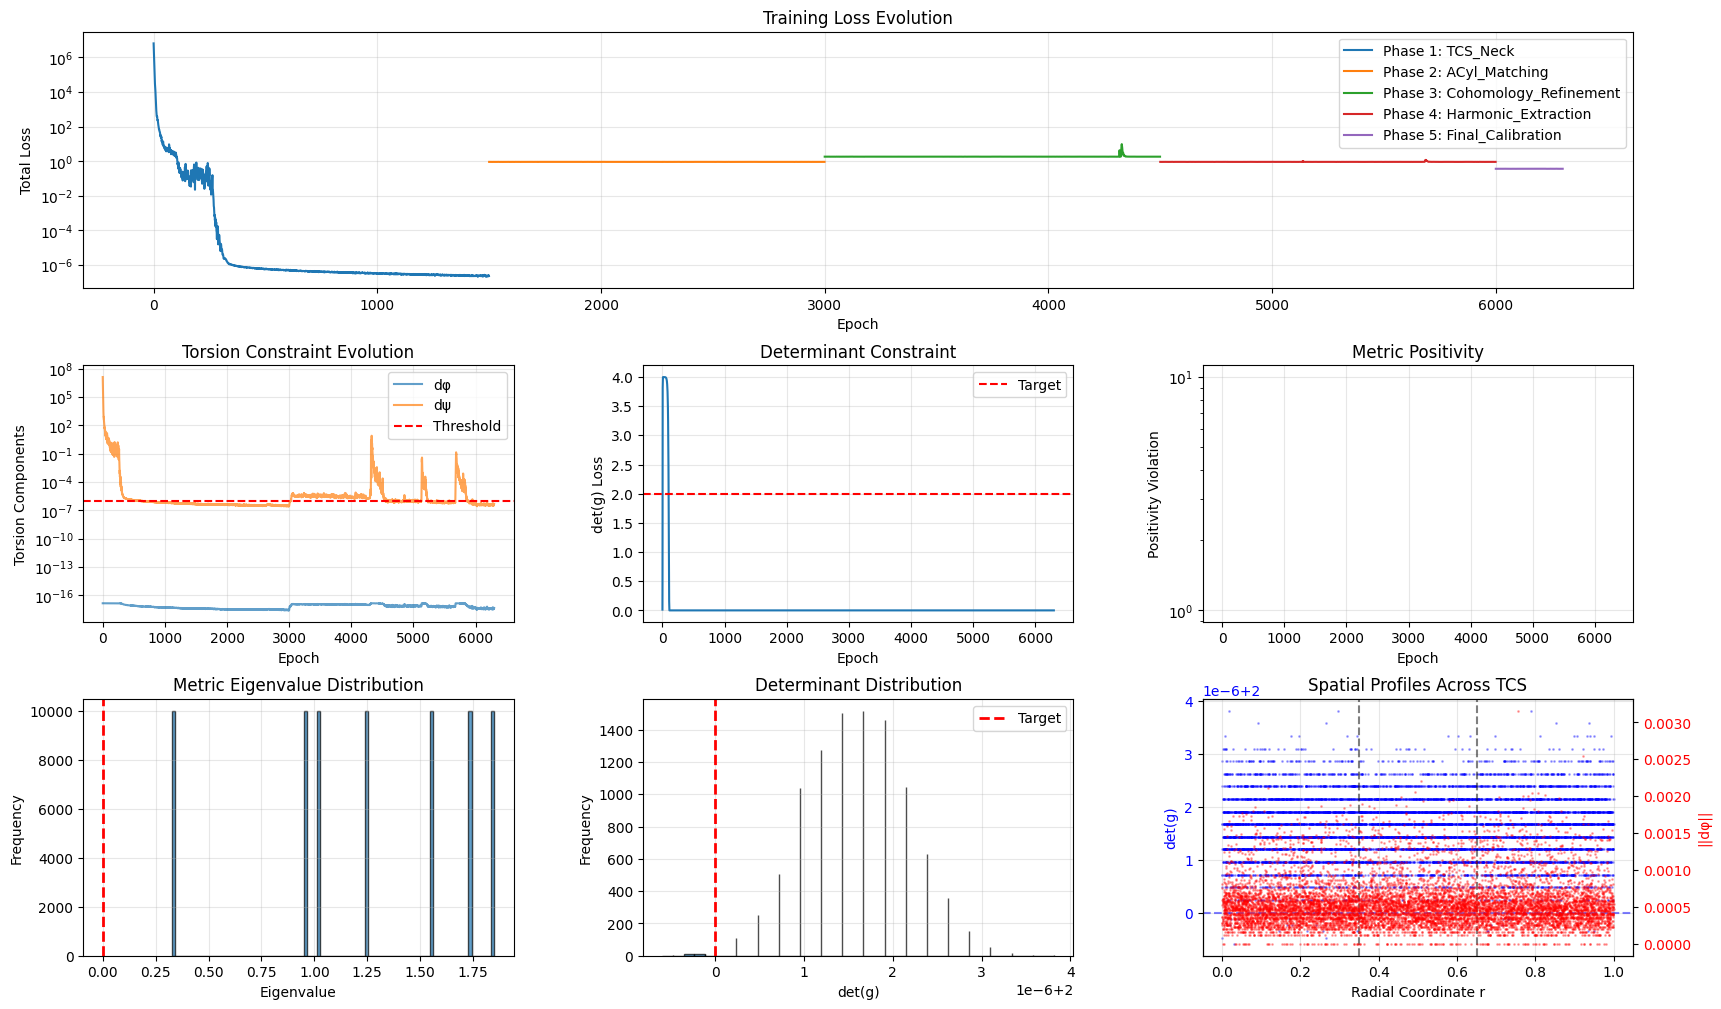

In [20]:
# ============================================================
# COMPREHENSIVE TRAINING & METRIC ANALYSIS
# ============================================================
# Insert this cell after Section 10 (Execute Training)

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

print("="*60)
print("COMPREHENSIVE TRAINING ANALYSIS")
print("="*60)

# ============================================================
# 1. TRAINING HISTORY DATAFRAME
# ============================================================
print("\n1. Training History Structure")
print("-"*60)

df_loss = pd.DataFrame(loss_history)
df_loss['global_epoch'] = range(len(df_loss))

print(f"Total training steps: {len(df_loss)}")
print(f"Phases completed: {df_loss['phase'].max()}")
print(f"\nPhase distribution:")
print(df_loss.groupby('phase').size())

# Save detailed CSV
df_loss.to_csv('training_history.csv', index=False)
print("\n✓ Saved: training_history.csv")

# ============================================================
# 2. PER-PHASE STATISTICS
# ============================================================
print("\n2. Per-Phase Statistics")
print("-"*60)

phase_stats = []
for phase_id in sorted(df_loss['phase'].unique()):
    phase_data = df_loss[df_loss['phase'] == phase_id]

    stats = {
        'phase': phase_id,
        'phase_name': CONFIG['phases'][phase_id]['name'],
        'epochs': len(phase_data),
        'loss_initial': phase_data['total'].iloc[0],
        'loss_final': phase_data['total'].iloc[-1],
        'loss_reduction': phase_data['total'].iloc[0] - phase_data['total'].iloc[-1],
        'loss_mean': phase_data['total'].mean(),
        'loss_std': phase_data['total'].std(),
        'dphi_final': phase_data['dphi'].iloc[-1],
        'dpsi_final': phase_data['dpsi'].iloc[-1],
        'det_final': phase_data['det'].iloc[-1],
        'positivity_final': phase_data['positivity'].iloc[-1],
    }
    phase_stats.append(stats)

df_phase_stats = pd.DataFrame(phase_stats)
print(df_phase_stats.to_string(index=False))

df_phase_stats.to_csv('phase_statistics.csv', index=False)
print("\n✓ Saved: phase_statistics.csv")

# ============================================================
# 3. CONVERGENCE ANALYSIS
# ============================================================
print("\n3. Convergence Analysis")
print("-"*60)

convergence_metrics = {
    'final_total_loss': df_loss['total'].iloc[-1],
    'min_total_loss': df_loss['total'].min(),
    'final_dphi': df_loss['dphi'].iloc[-1],
    'final_dpsi': df_loss['dpsi'].iloc[-1],
    'torsion_constraint_satisfied': df_loss['dphi'].iloc[-1] < CONFIG['torsion_threshold'],
    'early_stopped': 'early_stopped' in checkpoint_mgr.load_latest().get('metadata', {}) if checkpoint_mgr.load_latest() else False,
}

for key, value in convergence_metrics.items():
    print(f"  {key}: {value}")

# ============================================================
# 4. FINAL METRIC DETAILED ANALYSIS
# ============================================================
print("\n4. Final Metric Analysis")
print("-"*60)

phi_net.eval()
with torch.no_grad():
    # Sample extensively
    n_samples = 10000
    test_coords = torch.rand(n_samples, 7, device=device)

    # Compute metric
    phi_vals = phi_net(test_coords)
    g_vals, g_inv = compute_g2_metric(phi_vals, phase=5)
    g_corrected = geometry.acyl_metric_correction(test_coords, g_vals)
    g_normalized = normalize_metric(g_corrected, CONFIG['target']['det_g'])

    # Compute Hodge dual
    psi_vals = compute_hodge_dual(phi_vals, g_normalized, g_inv)

    # Compute exterior derivatives
    jacobian = extd.compute_jacobian(phi_net, test_coords)
    dphi = extd.d_phi(jacobian)
    dpsi_norm_scalar = extd.d_psi_norm(psi_vals, phi_net, test_coords)

    # Eigenvalue analysis
    g_sym = (g_normalized + g_normalized.transpose(-2, -1)) / 2.0
    eigvals = torch.linalg.eigvalsh(g_sym)

    # Determinant analysis
    det_g = torch.linalg.det(g_normalized)

    # Torsion analysis - compute per-point norms then aggregate
    dphi_per_point = torch.sqrt((dphi ** 2).sum(dim=(-4, -3, -2, -1)))
    dphi_norm_mean = dphi_per_point.mean()
    dphi_norm_max = dphi_per_point.max()
    dphi_norm_std = dphi_per_point.std()

metric_stats = {
    'eigenvalues': {
        'min': eigvals.min().item(),
        'max': eigvals.max().item(),
        'mean': eigvals.mean().item(),
        'std': eigvals.std().item(),
        'negative_count': (eigvals < 0).sum().item(),
        'positive_definite': (eigvals.min() > 0).item(),
    },
    'determinant': {
        'mean': det_g.mean().item(),
        'std': det_g.std().item(),
        'min': det_g.min().item(),
        'max': det_g.max().item(),
        'target': CONFIG['target']['det_g'],
        'error': abs(det_g.mean().item() - CONFIG['target']['det_g']),
    },
    'torsion': {
        'dphi_norm_mean': dphi_norm_mean.item(),
        'dphi_norm_max': dphi_norm_max.item(),
        'dphi_norm_std': dphi_norm_std.item(),
        'dpsi_norm': dpsi_norm_scalar.item(),
        'dphi_tensor_shape': list(dphi.shape),
        'target_norm': CONFIG['target']['torsion_norm'],
        'actual_norm': (dphi_norm_mean.item()**2 + dpsi_norm_scalar.item()**2)**0.5,
        'dphi_mean': dphi.mean().item(),
        'dphi_std': dphi.std().item(),
        'dphi_max': dphi.abs().max().item(),
    },
}

print("\nEigenvalue Statistics:")
for key, value in metric_stats['eigenvalues'].items():
    print(f"  {key}: {value}")

print("\nDeterminant Statistics:")
for key, value in metric_stats['determinant'].items():
    print(f"  {key}: {value}")

print("\nTorsion Statistics:")
for key, value in metric_stats['torsion'].items():
    print(f"  {key}: {value}")

# Save metric statistics
import json
with open('final_metric_analysis.json', 'w') as f:
    json.dump(metric_stats, f, indent=2)
print("\n✓ Saved: final_metric_analysis.json")

# ============================================================
# 5. SPATIAL DISTRIBUTION ANALYSIS
# ============================================================
print("\n5. Spatial Distribution Analysis")
print("-"*60)

r_coords = test_coords[:, 0].cpu().numpy()
regions = geometry.region_classification(test_coords[:, 0])

region_analysis = {
    'M1': {
        'count': regions['M1'].sum().item(),
        'fraction': regions['M1'].float().mean().item(),
        'det_mean': det_g[regions['M1']].mean().item() if regions['M1'].any() else 0,
        'det_std': det_g[regions['M1']].std().item() if regions['M1'].any() else 0,
        'dphi_norm_mean': dphi_per_point[regions['M1']].mean().item() if regions['M1'].any() else 0,
    },
    'Neck': {
        'count': regions['Neck'].sum().item(),
        'fraction': regions['Neck'].float().mean().item(),
        'det_mean': det_g[regions['Neck']].mean().item() if regions['Neck'].any() else 0,
        'det_std': det_g[regions['Neck']].std().item() if regions['Neck'].any() else 0,
        'dphi_norm_mean': dphi_per_point[regions['Neck']].mean().item() if regions['Neck'].any() else 0,
    },
    'M2': {
        'count': regions['M2'].sum().item(),
        'fraction': regions['M2'].float().mean().item(),
        'det_mean': det_g[regions['M2']].mean().item() if regions['M2'].any() else 0,
        'det_std': det_g[regions['M2']].std().item() if regions['M2'].any() else 0,
        'dphi_norm_mean': dphi_per_point[regions['M2']].mean().item() if regions['M2'].any() else 0,
    },
}

for region, stats in region_analysis.items():
    print(f"\n{region}:")
    for key, value in stats.items():
        print(f"  {key}: {value}")

# ============================================================
# 6. VISUALIZATION
# ============================================================
print("\n6. Generating Visualizations")
print("-"*60)

fig = plt.figure(figsize=(20, 12))
gs = GridSpec(3, 3, figure=fig, hspace=0.3, wspace=0.3)

# Loss evolution
ax1 = fig.add_subplot(gs[0, :])
for phase_id in sorted(df_loss['phase'].unique()):
    phase_data = df_loss[df_loss['phase'] == phase_id]
    ax1.semilogy(phase_data['global_epoch'], phase_data['total'],
                 label=f"Phase {phase_id}: {CONFIG['phases'][phase_id]['name']}")
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Total Loss')
ax1.set_title('Training Loss Evolution')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Torsion components
ax2 = fig.add_subplot(gs[1, 0])
ax2.semilogy(df_loss['global_epoch'], df_loss['dphi'], label='dφ', alpha=0.7)
ax2.semilogy(df_loss['global_epoch'], df_loss['dpsi'], label='dψ', alpha=0.7)
ax2.axhline(CONFIG['torsion_threshold'], color='r', linestyle='--', label='Threshold')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Torsion Components')
ax2.set_title('Torsion Constraint Evolution')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Determinant
ax3 = fig.add_subplot(gs[1, 1])
ax3.plot(df_loss['global_epoch'], df_loss['det'])
ax3.axhline(CONFIG['target']['det_g'], color='r', linestyle='--', label='Target')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('det(g) Loss')
ax3.set_title('Determinant Constraint')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Positivity
ax4 = fig.add_subplot(gs[1, 2])
ax4.semilogy(df_loss['global_epoch'], df_loss['positivity'])
ax4.set_xlabel('Epoch')
ax4.set_ylabel('Positivity Violation')
ax4.set_title('Metric Positivity')
ax4.grid(True, alpha=0.3)

# Eigenvalue distribution
ax5 = fig.add_subplot(gs[2, 0])
eigvals_np = eigvals.cpu().numpy()
ax5.hist(eigvals_np.flatten(), bins=100, alpha=0.7, edgecolor='black')
ax5.axvline(0, color='r', linestyle='--', linewidth=2)
ax5.set_xlabel('Eigenvalue')
ax5.set_ylabel('Frequency')
ax5.set_title('Metric Eigenvalue Distribution')
ax5.grid(True, alpha=0.3)

# Determinant distribution
ax6 = fig.add_subplot(gs[2, 1])
det_np = det_g.cpu().numpy()
ax6.hist(det_np, bins=100, alpha=0.7, edgecolor='black')
ax6.axvline(CONFIG['target']['det_g'], color='r', linestyle='--', linewidth=2, label='Target')
ax6.set_xlabel('det(g)')
ax6.set_ylabel('Frequency')
ax6.set_title('Determinant Distribution')
ax6.legend()
ax6.grid(True, alpha=0.3)

# Spatial profiles (determinant and torsion)
ax7 = fig.add_subplot(gs[2, 2])
r_sorted_idx = np.argsort(r_coords)
ax7_twin = ax7.twinx()

# Determinant on left axis
line1 = ax7.scatter(r_coords[r_sorted_idx], det_g.cpu().numpy()[r_sorted_idx],
           alpha=0.3, s=1, c='blue', label='det(g)')
ax7.axhline(CONFIG['target']['det_g'], color='b', linestyle='--', alpha=0.5)

# Torsion on right axis
line2 = ax7_twin.scatter(r_coords[r_sorted_idx], dphi_per_point.cpu().numpy()[r_sorted_idx],
           alpha=0.3, s=1, c='red', label='||dφ||')

# Neck boundaries
ax7.axvline(geometry.r_neck_start, color='k', linestyle='--', alpha=0.5, linewidth=1.5)
ax7.axvline(geometry.r_neck_end, color='k', linestyle='--', alpha=0.5, linewidth=1.5)

ax7.set_xlabel('Radial Coordinate r')
ax7.set_ylabel('det(g)', color='blue')
ax7_twin.set_ylabel('||dφ||', color='red')
ax7.tick_params(axis='y', labelcolor='blue')
ax7_twin.tick_params(axis='y', labelcolor='red')
ax7.set_title('Spatial Profiles Across TCS')
ax7.grid(True, alpha=0.3)

plt.savefig('final_results.png', dpi=300, bbox_inches='tight')
print("✓ Saved: final_results.png")

# ============================================================
# 7. YUKAWA ANALYSIS (if available)
# ============================================================
if 'Y_tensor' in locals():
    print("\n7. Yukawa Tensor Analysis")
    print("-"*60)

    yukawa_stats = {
        'shape': [int(s) for s in Y_tensor.shape],  # Convert to Python int
        'total_entries': int(np.prod(Y_tensor.shape)),  # Convert to Python int
        'norm': float(np.linalg.norm(Y_tensor)),
        'max_abs': float(np.abs(Y_tensor).max()),
        'mean_abs': float(np.abs(Y_tensor).mean()),
        'std': float(Y_tensor.std()),
        'non_zero_fraction': float((np.abs(Y_tensor) > 1e-10).mean()),
    }

    for key, value in yukawa_stats.items():
        print(f"  {key}: {value}")

    with open('yukawa_analysis.json', 'w') as f:
        json.dump(yukawa_stats, f, indent=2)
    print("\n✓ Saved: yukawa_analysis.json")

# ============================================================
# 8. FINAL SUMMARY
# ============================================================
print("\n" + "="*60)
print("ANALYSIS COMPLETE")
print("="*60)
print("\nGenerated files:")
print("  • training_history.csv - Complete loss history")
print("  • phase_statistics.csv - Per-phase summary")
print("  • final_metric_analysis.json - Detailed metric properties")
print("  • yukawa_analysis.json - Yukawa tensor statistics")
print("  • final_results.png - Comprehensive visualization")

print("\nKey Metrics:")
print(f"  Final loss: {convergence_metrics['final_total_loss']:.6e}")
print(f"  Torsion satisfied: {convergence_metrics['torsion_constraint_satisfied']}")
print(f"  Metric positive definite: {metric_stats['eigenvalues']['positive_definite']}")
print(f"  det(g) error: {metric_stats['determinant']['error']:.6e}")
print(f"  Torsion error: {abs(metric_stats['torsion']['actual_norm'] - CONFIG['target']['torsion_norm']):.6e}")
print("="*60)